### Analyzing a bike trip from Lyon to amsterdam 

We parse Strava gpx files and see what stats and plot we can make.

In [145]:
import gpxpy
import os
from glob import glob
import pandas as pd
pd.set_option('display.max_rows', 200)
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
from geopy import distance
from shapely.geometry import Point, Polygon

PATH = '/home/diederik/ams/pyprojects/geospatial_analysis/data/strava/'
p = Path(PATH)
files = list(p.rglob('*.gpx*'))

In [3]:
def load_bike_data(gpx_files_path, filter=""):
    files = list(p.rglob('*.gpx*'))
    
    track_data = []
    
    for file_idx, file in enumerate(files): 
        gpx = gpxpy.parse(open(file, 'r'))
        # Loop through tracks
        for track_idx, track in enumerate(gpx.tracks):
            track_name = track.name
            track_time = track.get_time_bounds().start_time
            track_length = track.length_3d()
            track_duration = track.get_duration()
            track_speed = track.get_moving_data().max_speed
            
            for i, segment in enumerate(track.segments):
                segment_length = segment.length_3d()
                for point_idx, point in enumerate(segment.points):
                    track_data.append([file_idx, os.path.basename(file), track_idx, track_name, 
                                     track_time, track_length, track_duration, track_speed, 
                                     i, segment_length, point.time, point.latitude, 
                                     point.longitude, point.elevation, segment.get_speed(i)])
    return track_data

In [4]:
def create_dateparts_columns(df, datetime_col, date_fmt):
    """
    Convert string date column to datetime and add date, day, weekday and hour columns to dataframe
    INPUT:
    df: pandas df
    datetime_col: name column to be converted to datetime
    date_fmt: string format of datetime column
    RETURNS:
    dataframe with extra columns
    """
    df['point_time'] = pd.to_datetime(df[datetime_col], format = date_fmt)
    df = df.assign(date = lambda x: x.point_time.dt.date,
                   day = lambda x: x.point_time.dt.day,
                   weekday = lambda x: x.point_time.dt.weekday,
                   hour = lambda x: x.point_time.dt.hour)
    return df

In [140]:
data = load_bike_data(gpx_files_path=PATH, filter="")
df = pd.DataFrame(data, columns=['file_index', 'file_name', 'index', 'etappe',
                              'time', 'length', 'duration', 'max_speed',
                              'segment_index', 'segment_length', 'point_time', 'lat',
                              'lon', 'elev', 'speed'])
df = create_dateparts_columns(df, datetime_col='point_time', date_fmt='%Y-%m-%d %H:%M:%S')
# to geopandas
#df = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'})
#df['geometry'] = df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)

In [277]:
test = df[df.file_index == 0]

In [278]:
test = test.copy()
test['time'] = test.point_time.dt.time
test['start_time'] = 'no'
test.loc[test.point_time == test.point_time.iloc[0], 'start_time'] = 'start_time'
test.loc[test.point_time == test.point_time.iloc[-1], 'start_time'] = 'end_time'

In [279]:
test = test.set_index('point_time').sort_index(ascending=True)

In [379]:
#https://codeburst.io/dealing-with-datetimes-like-a-pro-in-pandas-b80d3d808a7f
#df['week_start'] = df.index.to_period('W').start_time

In [280]:
date = test['date'][0]
time_range = pd.date_range(f"{date} 00:00:00",  f"{date} 23:00:00", freq='1min')

In [281]:
# duration to hours
test['duration'] = test['duration']/60/60

In [282]:
# length to km 
test['length'] = test.length / 1000

In [285]:
# elev_change
test['elev_change'] = test.elev.subtract(test.elev.shift(1))

In [ ]:
# segment index
test['segment_index'] = pd.Series(range(0, len(test)),dtype='int', index=test.index)

In [315]:
segment_dist_list_ = []
for i in range(0, len(test.segment_index)):
    # 
    if i < range(0, len(test.segment_index))[-1]:
        (segment_dist_list_.append(
            distance.vincenty(
             tuple((test.loc[(test.segment_index == i, ['lat', 'lon'])].values)
                   .reshape(1, -1)[0]),
             tuple((test.loc[(test.segment_index == i + 1, ['lat', 'lon'])].values)
                   .reshape(1, -1)[0]))
            .km)
        )
    else:
        segment_dist_list_.append(0)

In [320]:
test['segment_length'] = pd.DataFrame(list_, index=test.index)

,file_index,file_name,index,etappe,time,length,duration,max_speed,segment_index,segment_length,lat,lon,elev,speed,date,day,weekday,hour,start_time,elev_change
point_time,,,,,,,,,,,,,,,,,,,,
2018-08-09 04:26:22,0,11_tape_11_Achouffe_Eindhoven.gpx,0,Étape 11# Achouffe - Eindhoven,04:26:22,212.903315,12.159722,13.2689,0,0.005093,50.164228,5.673490,412.8,5.082558,2018-08-09,9,3,4,start_time,NaN
2018-08-09 04:26:23,0,11_tape_11_Achouffe_Eindhoven.gpx,0,Étape 11# Achouffe - Eindhoven,04:26:23,212.903315,12.159722,13.2689,1,0.005046,50.164232,5.673561,412.8,5.082558,2018-08-09,9,3,4,no,0.0
2018-08-09 04:26:24,0,11_tape_11_Achouffe_Eindhoven.gpx,0,Étape 11# Achouffe - Eindhoven,04:26:24,212.903315,12.159722,13.2689,2,0.004975,50.164238,5.673631,412.6,5.082558,2018-08-09,9,3,4,no,-0.2
2018-08-09 04:26:25,0,11_tape_11_Achouffe_Eindhoven.gpx,0,Étape 11# Achouffe - Eindhoven,04:26:25,212.903315,12.159722,13.2689,3,0.004941,50.164244,5.673700,412.8,5.082558,2018-08-09,9,3,4,no,0.2
2018-08-09 04:26:26,0,11_tape_11_Achouffe_Eindhoven.gpx,0,Étape 11# Achouffe - Eindhoven,04:26:26,212.903315,12.159722,13.2689,4,0.010025,50.164247,5.673769,412.6,5.082558,2018-08-09,9,3,4,no,-0.2


# plots 

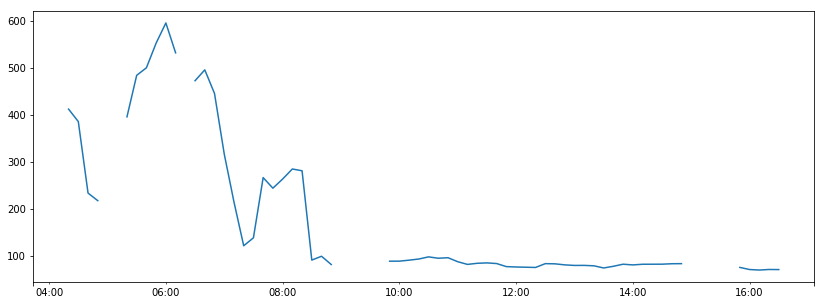

In [157]:
test = test.set_index('point_time')
fig, ax = plt.subplots(figsize=[14,5])
(test.sort_index().reindex(time_range,fill_value=np.nan)
 .resample('10min')['elev'].mean().plot(ax=ax))

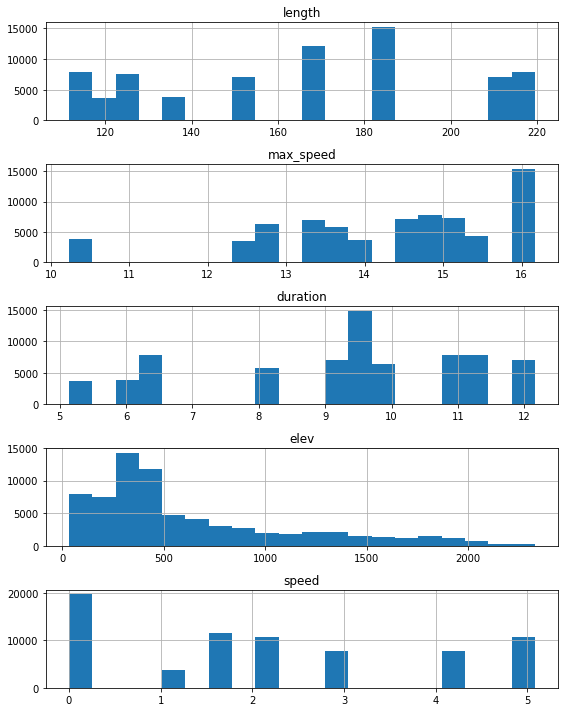

In [96]:
num_cols = ['length', 'max_speed', 'duration', 'elev', 'speed']
fig, ax = plt.subplots(len(num_cols), 1, figsize= [8,10])

for i, col in enumerate(df[num_cols].columns):
    df[col].hist(bins=20, ax=ax[i])
    ax[i].set_title(col)
plt.tight_layout()

In [231]:
df['elev_bins'] = pd.cut(df['elev'], bins = [0, 500, 1000, 1500, 2000], 
                         labels=['0-500', '500-1000', '1000-1500', '1500-2000'])

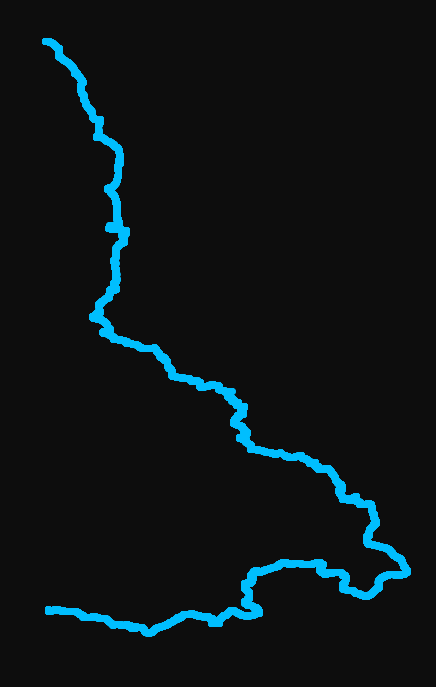

In [234]:
fig,ax = plt.subplots(figsize = [12,12], facecolor = '0.05')
ax.set_aspect('equal')
ax.set_axis_off()
df.plot(color = 'deepskyblue', lw = 0.9, alpha = 0.8, ax=ax)